In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_10_images(data):    
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(data[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from classifier import create_model

classifier = create_model()
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],)

In [3]:
import os
from keras.utils.np_utils import to_categorical


weight_file = './weights/mnist_classifier.hd5'

if(os.path.exists(weight_file)):
    classifier.load_weights(weight_file)
else:
    classifier.fit(x_train, to_categorical(y_train),
                    epochs=100,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test, to_categorical(y_test)), 
                    callbacks=[])

    classifier.save_weights(weight_file)

In [6]:
loss, acc = classifier.evaluate(x_test, to_categorical(y_test), batch_size=128)

print("Model loss:", loss)
print("Model accuracy:", acc)

10000/10000 [==============================] - 0s 21us/step
Model loss: 0.028953129138035
Model accuracy: 0.9911


# Calculate baseline softmax and ODIN AUROC

In [13]:
from keras.layers import Lambda, Input, Activation
from keras.models import Model, clone_model
import keras.backend as K
NUM_CLASSES = 10


def create_odin_model(epsilon, temperature):
    image = Input(shape=(28, 28, 1))
    image_cp = Lambda(lambda x: x)(image)
    
    new_classifier = clone_model(classifier)
    new_classifier.load_weights(weight_file)
    softmax = new_classifier.layers.pop()

    # Do first pass
    x = new_classifier(image_cp)
    
    # Get gradients wrt input image
    pred_target = Lambda(lambda x: K.one_hot(K.argmax(x, axis=1), num_classes=NUM_CLASSES))(x)
    loss = Lambda(lambda x: K.binary_crossentropy(x[0], x[1]))([pred_target, x])
    grad = Lambda(lambda x: K.gradients(loss, image_cp))(x)
    grad = Lambda(lambda x: x * epsilon)(grad)

    # Use gradient to perturb image then classify it
    x = Lambda(lambda x: x[0] - x[1])([image_cp, grad])
    x = new_classifier(x)

    # Do the temp scaling
    x = Lambda(lambda x: x / temperature)(x)
    x = Lambda(lambda x: x - K.max(x, axis=0))(x)
    output = softmax(x)
    
    return Model(inputs=image, outputs=output)

## Fashion MNIST

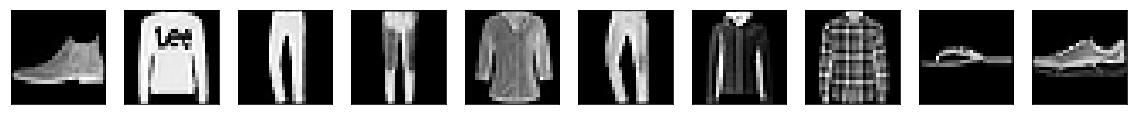

In [5]:
from keras.datasets import fashion_mnist
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

_, (fashion_x_test, _) = fashion_mnist.load_data()

fashion_x_test = fashion_x_test.astype('float32') / 255.
fashion_x_test = np.reshape(fashion_x_test, (len(x_test), 28, 28, 1))

show_10_images(fashion_x_test)

In [6]:
labels = len(x_test) * [0] + len(fashion_x_test) * [1]
test_samples = np.concatenate((x_test, fashion_x_test))

losses = classifier.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("Base AUROC:", roc_auc_score(labels, losses))

odin = create_odin_model(epsilon=0.0012, temperature=1000.)
losses = odin.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("ODIN AUROC:", roc_auc_score(labels, losses))

Base AUROC: 0.9908385049999999
ODIN AUROC: 0.99834169


## EMNIST Letters

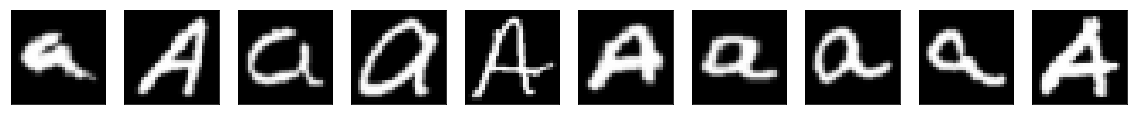

In [7]:
from torchvision.datasets import EMNIST

emnist_letters = EMNIST('./', "letters", train=False, download=True)
emnist_letters = emnist_letters.test_data.numpy()
emnist_letters = emnist_letters.astype('float32') / 255.

emnist_letters = np.reshape(emnist_letters, (len(emnist_letters), 28, 28, 1))
emnist_letters = np.swapaxes(emnist_letters, 1, 2)

show_10_images(emnist_letters)

In [8]:
labels = len(x_test) * [0] + len(emnist_letters) * [1]
test_samples = np.concatenate((x_test, emnist_letters))

losses = classifier.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("Base AUROC:", roc_auc_score(labels, losses))

odin = create_odin_model(epsilon=0.0012, temperature=1000.)
losses = odin.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("ODIN AUROC:", roc_auc_score(labels, losses))

Base AUROC: 0.9140684158653847
ODIN AUROC: 0.9979355120192307


## Gaussian noise

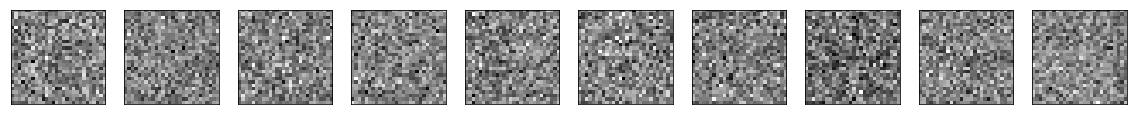

In [9]:
mnist_mean = np.mean(x_train)
mnist_std = np.std(x_train)
gaussian_data = np.random.normal(mnist_mean, mnist_std, size=(10000, 28, 28, 1))

show_10_images(gaussian_data)

In [10]:
labels = len(x_test) * [0] + len(gaussian_data) * [1]
test_samples = np.concatenate((x_test, gaussian_data))

losses = classifier.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("Base AUROC:", roc_auc_score(labels, losses))

odin = create_odin_model(epsilon=0.0012, temperature=1000.)
losses = odin.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("ODIN AUROC:", roc_auc_score(labels, losses))

Base AUROC: 0.9933223449999998
ODIN AUROC: 0.99938433


## Uniform noise

MNIST mean: 0.13066062
Uniform mean: 0.13062479993442475
MNIST std: 0.30810776
Uniform std: 0.30807410253143047


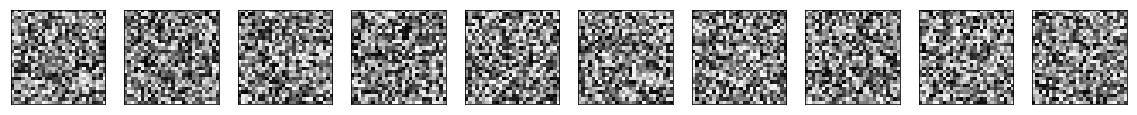

In [11]:
import math
b = math.sqrt(3.) * mnist_std
a = -b + mnist_mean
b += mnist_mean

uniform_data = np.random.uniform(low=a, high=b, size=(10000, 28, 28, 1))

print("MNIST mean:", mnist_mean)
print("Uniform mean:", np.mean(uniform_data))
print("MNIST std:", mnist_std)
print("Uniform std:", np.std(uniform_data))

show_10_images(uniform_data)

In [12]:
labels = len(x_test) * [0] + len(uniform_data) * [1]
test_samples = np.concatenate((x_test, uniform_data))

losses = classifier.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("Base AUROC:", roc_auc_score(labels, losses))

odin = create_odin_model(epsilon=0.0012, temperature=1000.)
losses = odin.predict(test_samples)
losses = -np.max(losses, axis=-1)
print("ODIN AUROC:", roc_auc_score(labels, losses))

Base AUROC: 0.993905785
ODIN AUROC: 0.9994433450000001
